### 1. IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

### 2. LOAD DATA

In [2]:
df = pd.read_csv("Sales Dataset.csv")

df_raw = df.copy()

print("Jumlah Baris & Kolom:", df.shape)
print("\nTipe Data:\n", df.dtypes)
print("\nStatistik Numerik:\n", df.describe())

Jumlah Baris & Kolom: (1194, 12)

Tipe Data:
 Order ID        object
Amount           int64
Profit           int64
Quantity         int64
Category        object
Sub-Category    object
PaymentMode     object
Order Date      object
CustomerName    object
State           object
City            object
Year-Month      object
dtype: object

Statistik Numerik:
             Amount       Profit     Quantity
count  1194.000000  1194.000000  1194.000000
mean   5178.089615  1348.992462    10.674204
std    2804.921955  1117.992573     5.777102
min     508.000000    50.000000     1.000000
25%    2799.000000   410.000000     6.000000
50%    5152.000000  1014.000000    11.000000
75%    7626.000000  2035.000000    16.000000
max    9992.000000  4930.000000    20.000000


### 3. DATA CLEANING

In [3]:
df.drop_duplicates(inplace=True)

print("Missing Values per Column:\n", df.isnull().sum())

df["Order Date"] = pd.to_datetime(df["Order Date"], errors='coerce')

num_cols = ["Amount","Profit","Quantity"]

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

outlier_mask = ((df[num_cols] < (Q1 - 1.5 * IQR)) | 
                (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

print("Jumlah Outlier:", outlier_mask.sum())

Missing Values per Column:
 Order ID        0
Amount          0
Profit          0
Quantity        0
Category        0
Sub-Category    0
PaymentMode     0
Order Date      0
CustomerName    0
State           0
City            0
Year-Month      0
dtype: int64
Jumlah Outlier: 10



Distribusi nilai untuk Category:

Category
Furniture          407
Office Supplies    399
Electronics        388
Name: count, dtype: int64


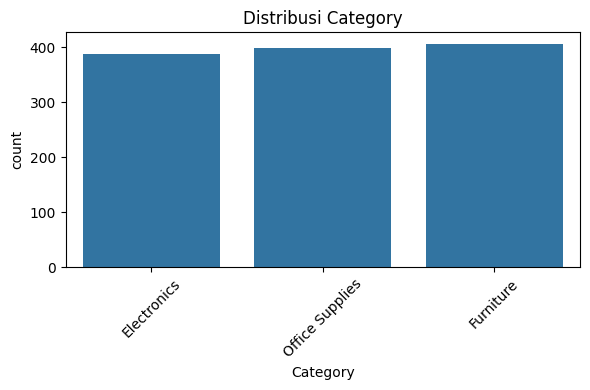


Distribusi nilai untuk City:

City
Buffalo          90
San Francisco    84
Orlando          77
Rochester        74
San Diego        73
Dallas           72
Cleveland        70
Springfield      68
Miami            66
Austin           65
Chicago          63
New York City    62
Los Angeles      61
Cincinnati       61
Tampa            57
Houston          52
Peoria           50
Columbus         49
Name: count, dtype: int64


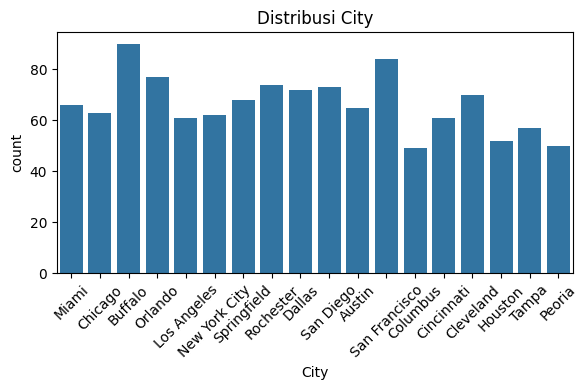


Distribusi nilai untuk Sub-Category:

Sub-Category
Tables              122
Pens                114
Sofas               114
Markers             110
Electronic Games    104
Paper               104
Phones              101
Printers             95
Laptops              88
Bookcases            88
Chairs               83
Binders              71
Name: count, dtype: int64


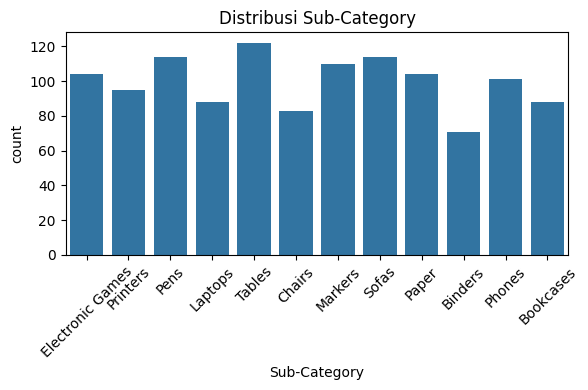

In [4]:
cat_cols = ["Category", "City", "Sub-Category"]

for col in cat_cols:
    print(f"\nDistribusi nilai untuk {col}:\n")
    print(df[col].value_counts())

    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Distribusi {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

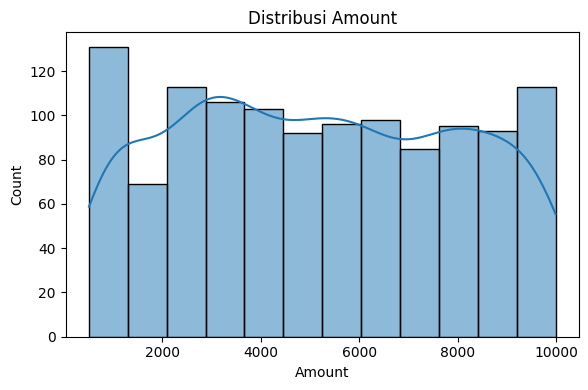

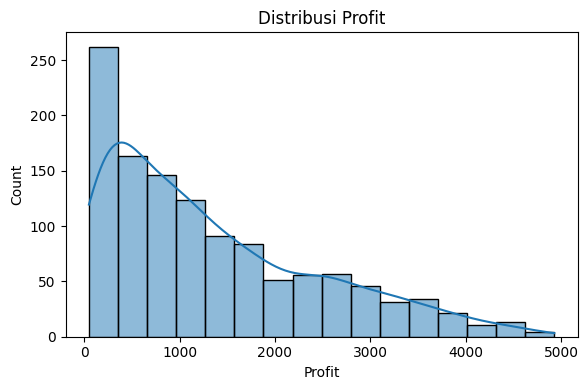

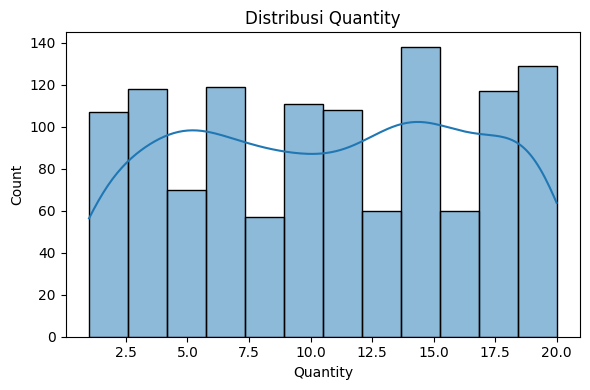

In [5]:
num_cols = ["Amount", "Profit", "Quantity"]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribusi {col}")
    plt.tight_layout()
    plt.show()

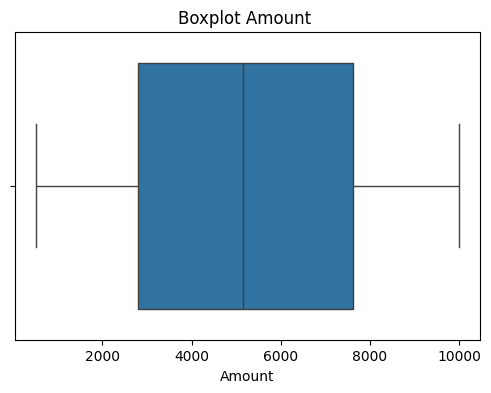

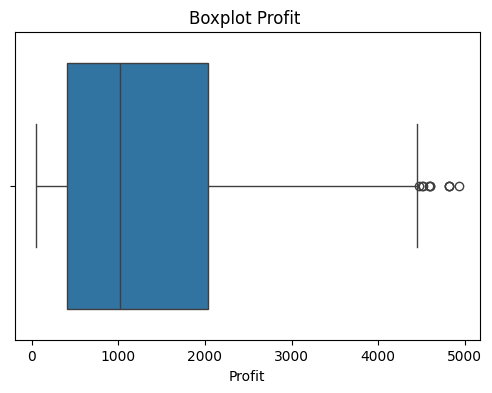

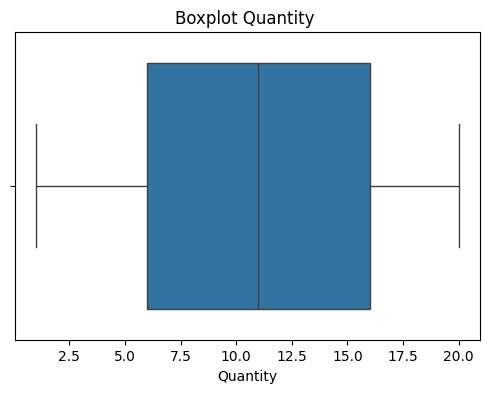

In [6]:
num_cols = ["Amount", "Profit", "Quantity"]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot {col} ")
    plt.show()


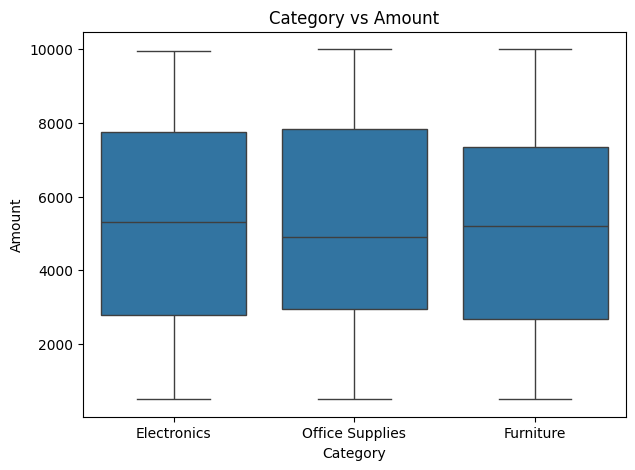

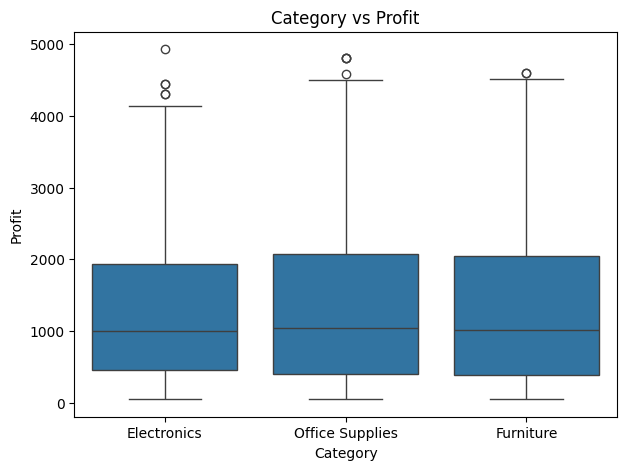

In [7]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="Category", y="Amount")
plt.title("Category vs Amount")
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="Category", y="Profit")
plt.title("Category vs Profit")
plt.show()


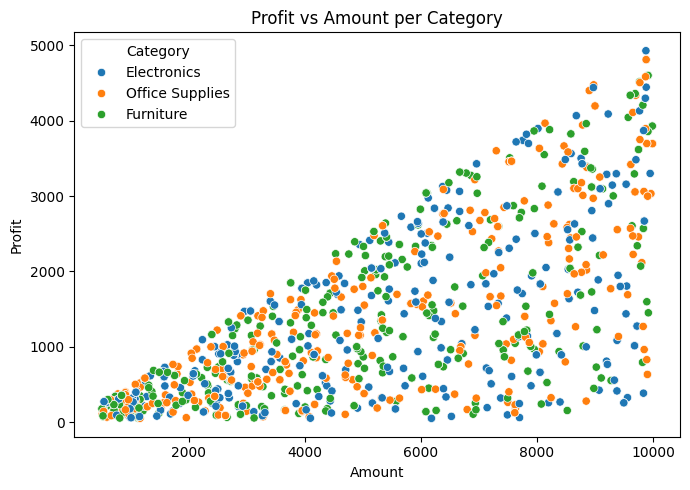

In [8]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="Amount", y="Profit", hue="Category")
plt.title("Profit vs Amount per Category")
plt.tight_layout()
plt.show()

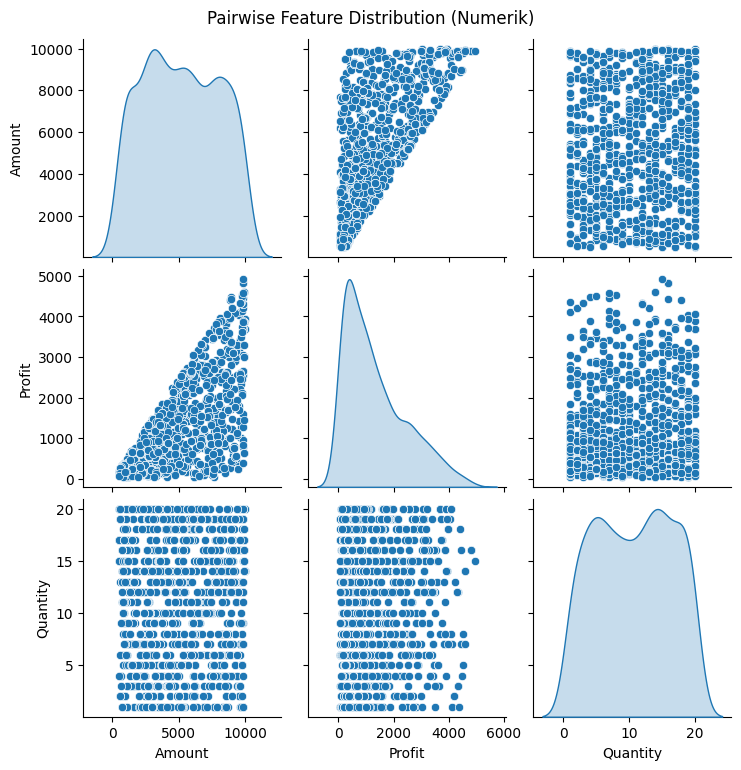

In [9]:
sns.pairplot(df[num_cols], diag_kind="kde")
plt.suptitle("Pairwise Feature Distribution (Numerik)", y=1.02)
plt.show()


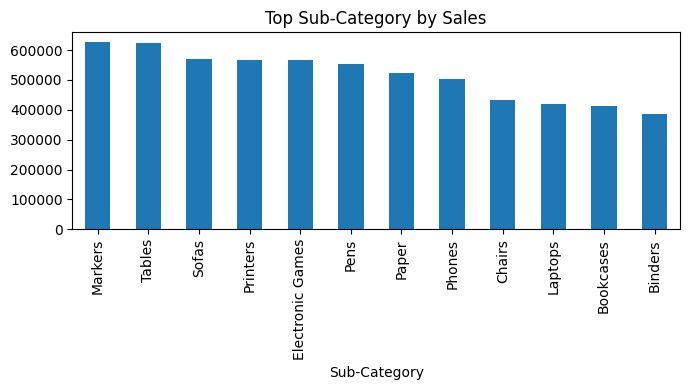

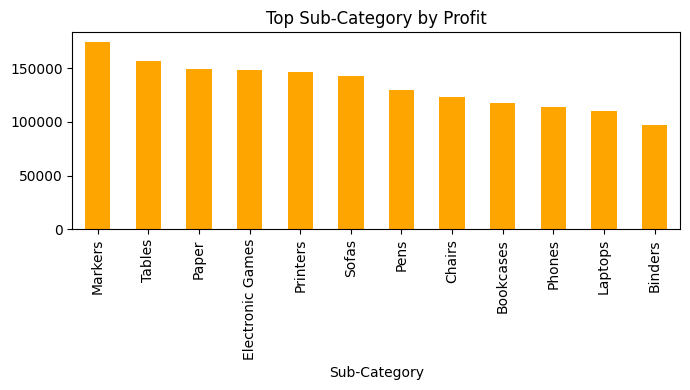

In [10]:
top_sales = df.groupby("Sub-Category")["Amount"].sum().sort_values(ascending=False)
top_profit = df.groupby("Sub-Category")["Profit"].sum().sort_values(ascending=False)

plt.figure(figsize=(7,4))
top_sales.plot(kind='bar')
plt.title("Top Sub-Category by Sales")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
top_profit.plot(kind='bar', color='orange')
plt.title("Top Sub-Category by Profit")
plt.tight_layout()
plt.show()

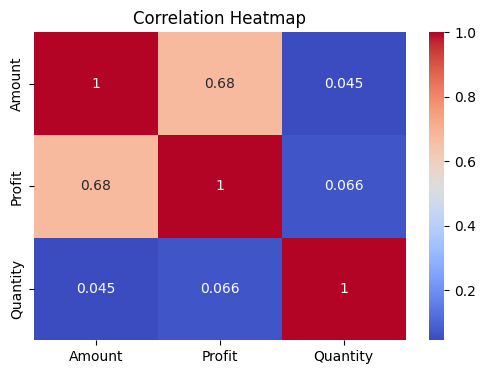

In [11]:
plt.figure(figsize=(6,4))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

### 4. FEATURE ENGINEERING

In [12]:
df["Year"]  = df["Order Date"].dt.year
df["Month"] = df["Order Date"].dt.month

# Frequency Encoding for City & Sub-Category
for col in ["City","Sub-Category"]:
    freq = df[col].value_counts(normalize=True)
    df[f"{col}_freq"] = df[col].map(freq)

### 5. FEATURE SELECTION

In [13]:
num_features  = ["Amount","Profit","Quantity"]
cat_features  = ["Category","PaymentMode"]
freq_features = ["City_freq","Sub-Category_freq"]
time_features = ["Year","Month"]

all_features  = num_features + cat_features + freq_features + time_features

### 6. PREPROCESSING PIPELINE

In [14]:
preprocess = ColumnTransformer([
    ("num", RobustScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
    ("freq","passthrough", freq_features),
    ("time","passthrough", time_features)
])

pipeline = Pipeline([("prep", preprocess)])

X = pipeline.fit_transform(df[all_features])

### 7. MODELING → K-MEANS (k=2)

In [15]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)
df["cluster"] = labels

### 8. MODEL EVALUATION

In [16]:
sil_score = silhouette_score(X, labels)
print("\nSilhouette Score (k=2):", sil_score)

joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(pipeline, "pipeline.pkl")

print("\nModel and pipeline saved successfully!")
print("Saved files:")
print(" - kmeans_model.pkl")
print(" - pipeline.pkl")

# OPTIONAL: Save clustered dataset
df.to_csv("clustered_output.csv", index=False)
print("Clustered dataset saved: clustered_output.csv")


Silhouette Score (k=2): 0.30209901433468905

Model and pipeline saved successfully!
Saved files:
 - kmeans_model.pkl
 - pipeline.pkl
Clustered dataset saved: clustered_output.csv


### 9. VISUALISASI

#### A. Elbow Plot

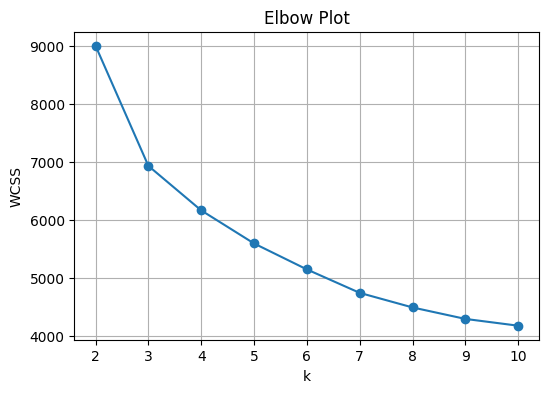

In [17]:
wcss = []
for k in range(2,11):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X)
    wcss.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2,11), wcss, marker='o')
plt.title("Elbow Plot")
plt.xlabel("k")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

#### B. Silhouette Plot

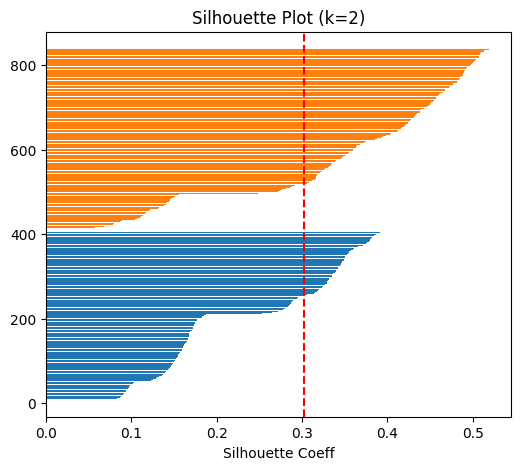

In [18]:
sil_vals = silhouette_samples(X, labels)
y_lower = 10

plt.figure(figsize=(6,5))
for i in range(2):
    cluster_vals = sil_vals[labels == i]
    cluster_vals.sort()
    y_upper = y_lower + len(cluster_vals)
    plt.barh(range(y_lower, y_upper), cluster_vals)
    y_lower = y_upper + 10

plt.axvline(sil_score, linestyle='--', color='red')
plt.title("Silhouette Plot (k=2)")
plt.xlabel("Silhouette Coeff")
plt.show()

#### C. PCA 2D Visualization

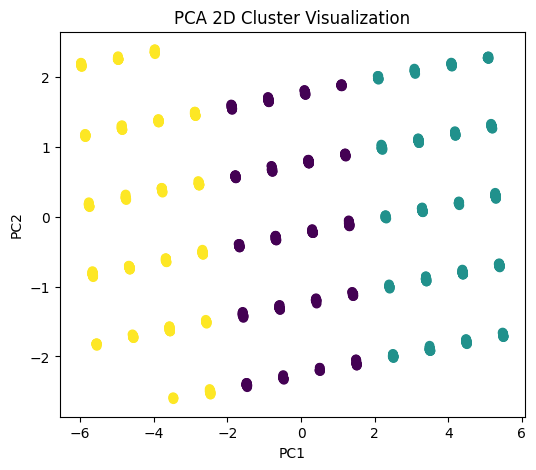

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis')
plt.title("PCA 2D Cluster Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#### D. Heatmap Rata-rata Numerik per Cluster

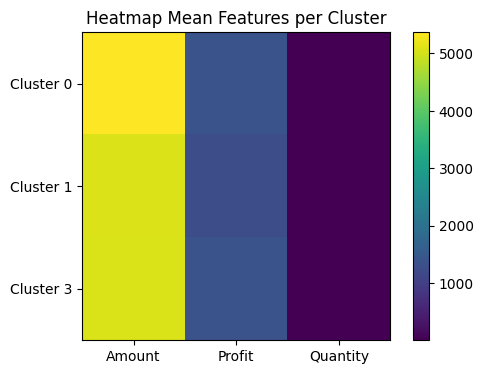

In [20]:
cluster_mean = df.groupby("cluster")[num_features].mean()

plt.figure(figsize=(6,4))
plt.imshow(cluster_mean, cmap="viridis")
plt.colorbar()
plt.xticks(range(len(num_features)), num_features)
plt.yticks([0,1,2], ["Cluster 0","Cluster 1","Cluster 3"])
plt.title("Heatmap Mean Features per Cluster")
plt.show()